In [1]:
import pandas as pd
import numpy as np
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold,StratifiedShuffleSplit,KFold,train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor
from scipy.optimize import minimize
from tqdm import tqdm
from xgboost import XGBRegressor
import copy
import optuna

In [ ]:
#data
train=pd.read_csv("../dataset/train_features.csv")
y=pd.read_csv("../dataset/train_labels.csv")
test=pd.read_csv("../dataset/test_features.csv")
ss=pd.read_csv("../dataset/submission_format.csv")
test_ground_truth=pd.read_csv("../dataset/sdoh_test_labels.csv")

In [3]:
train.head(2)

uid age_03 urban_03 married_03  n_mar_03 edu_gru_03 n_living_child_03  \
0  aace    NaN      NaN        NaN       NaN        NaN               NaN   
1  aanz    NaN      NaN        NaN       NaN        NaN               NaN   

   migration_03 glob_hlth_03  adl_dress_03  ...           rrelgimp_12  \
0           NaN          NaN           NaN  ...  2.somewhat important   
1           NaN          NaN           NaN  ...      1.very important   

   rrfcntx_m_12        rsocact_m_12  rrelgwk_12  a16a_12  a21_12  a22_12  \
0       9.Never             9.Never        0.No      NaN     NaN     NaN   
1       9.Never  1.Almost every day        0.No      NaN     NaN     NaN   

   a33b_12  a34_12      j11_12  
0      NaN     NaN  Concrete 2  
1      NaN     NaN  Concrete 2  

[2 rows x 184 columns]

In [4]:
test.head(2)

uid age_03 urban_03 married_03  n_mar_03 edu_gru_03 n_living_child_03  \
0  abxu    NaN      NaN        NaN       NaN        NaN               NaN   
1  aeol    NaN      NaN        NaN       NaN        NaN               NaN   

   migration_03 glob_hlth_03  adl_dress_03  ...       rrelgimp_12  \
0           NaN          NaN           NaN  ...               NaN   
1           NaN          NaN           NaN  ...  1.very important   

   rrfcntx_m_12  rsocact_m_12  rrelgwk_12  a16a_12  a21_12  a22_12  a33b_12  \
0           NaN           NaN         NaN      NaN     NaN     NaN      NaN   
1       9.Never       9.Never       1.Yes      NaN     NaN     NaN      NaN   

   a34_12                             j11_12  
0     NaN  Wood, mosaic, or other covering 1  
1     NaN                         Concrete 2  

[2 rows x 184 columns]

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Columns: 184 entries, uid to j11_12
dtypes: float64(140), object(44)
memory usage: 4.6+ MB


In [6]:
#let merge train and label
merged_df = pd.merge(train, y, on='uid', how='left')

In [7]:
merged_df["year"]

0       2021
1       2021
2       2016
3       2021
4       2021
        ... 
4338    2021
4339    2016
4340    2021
4341    2021
4342    2021
Name: year, Length: 4343, dtype: int64

In [8]:
#so many missing values
merged_df.isnull().sum()

uid                   0
age_03             1456
urban_03           1454
married_03         1454
n_mar_03           1482
                   ... 
a33b_12            4288
a34_12             1601
j11_12               89
year                  0
composite_score       0
Length: 186, dtype: int64

In [9]:
#lets merged test AND sample submission
merged_test = pd.merge(test, ss, on='uid', how='left')

In [10]:
merged_test["year"]

0       2016
1       2016
2       2021
3       2016
4       2021
        ... 
1100    2016
1101    2021
1102    2016
1103    2021
1104    2021
Name: year, Length: 1105, dtype: int64

<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

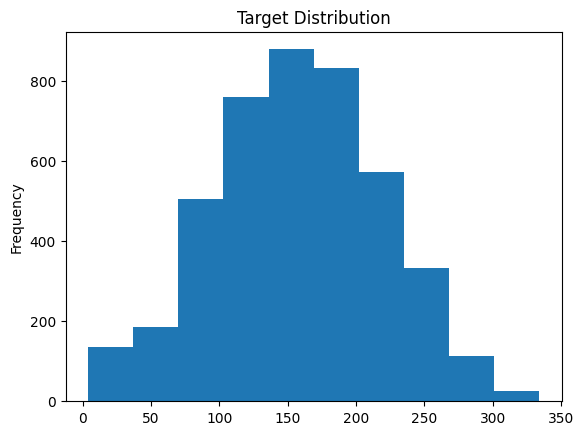

In [11]:
merged_df['composite_score'].plot(kind='hist',title='Target Distribution')

In [12]:
# create new features by combining 2003 and 2012 scores and numbering ordinal variables
def feature_engineering(data):
    data['rjob_hrswk_change'] = (data['rjob_hrswk_12'] - data['rjob_hrswk_03']).astype(float)
    data['max_work_year']=data[['rjob_end_12','rjob_end_03']].max(axis=1).astype(float)
    data['years_since_work']=(data['year']-data['max_work_year']).astype(float)
    data['hincome_change']=(data['hincome_12']-data['hincome_03']).astype(float)
    data['niadl_change']=(data['n_iadl_12']-data['n_iadl_03']).astype(float)
    data['adl_change']=(data['n_adl_12']-data['n_adl_03']).astype(float)
    data['depr_change']=(data['n_depr_12']-data['n_depr_03']).astype(float)
    data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_change']=(data['glob_hlth_12']-data['glob_hlth_03']).astype(float)
    data['bmi_03']=data['bmi_03'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_12']=data['bmi_12'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_change']=(data['bmi_12']-data['bmi_03']).astype(float)
    data['employment_03']=data['employment_03'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['employment_12']=data['employment_12'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['memory_12']=data['memory_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['edu_gru_03']=data['edu_gru_03'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_12']=data['edu_gru_12'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_change']=(data['edu_gru_12']-data['edu_gru_03']).astype(float)
    data['illnesses_change']=(data['n_illnesses_12']-data['n_illnesses_03']).astype(float)
    return data

In [13]:
# create new features by combining 2003 and 2012 scores and numbering ordinal variables
"""def feature_engineering(data):
    data['rjob_hrswk_change'] = (data['rjob_hrswk_12'] - data['rjob_hrswk_03']).astype(float)
    data['max_work_year']=data[['rjob_end_12','rjob_end_03']].max(axis=1).astype(float)
    data['years_since_work']=(data['year']-data['max_work_year']).astype(float)
    data['hincome_change']=(data['hincome_12']-data['hincome_03']).astype(float)
    data['niadl_change']=(data['n_iadl_12']-data['n_iadl_03']).astype(float)
    data['adl_change']=(data['n_adl_12']-data['n_adl_03']).astype(float)
    data['depr_change']=(data['n_depr_12']-data['n_depr_03']).astype(float)
    data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_change']=(data['glob_hlth_12']-data['glob_hlth_03']).astype(float)
    data['bmi_03']=data['bmi_03'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_12']=data['bmi_12'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_change']=(data['bmi_12']-data['bmi_03']).astype(float)
    data['employment_03']=data['employment_03'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['employment_12']=data['employment_12'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['memory_12']=data['memory_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['edu_gru_03']=data['edu_gru_03'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_12']=data['edu_gru_12'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_change']=(data['edu_gru_12']-data['edu_gru_03']).astype(float)
    data['illnesses_change']=(data['n_illnesses_12']-data['n_illnesses_03']).astype(float)
    data['has_migrated'] = data.apply(
        lambda row: float('nan') if (pd.isna(row['urban_03']) or pd.isna(row['urban_12']))
        else (1 if row['urban_03'] != row['urban_12'] else 0),
        axis=1
    )
    data['depr_change']=(data['n_depr_12']-data['n_depr_03']).astype(float)
    
    
    # Start or stop alcohol use
    data['start_alcohol'] = data.apply(
        lambda row: float('nan') if (pd.isna(row['alcohol_03']) or pd.isna(row['alcohol_12']))
        else (1 if row['alcohol_03'] == 0 and row['alcohol_12'] == 1 else 0),
        axis=1
    )
    data['stop_alcohol'] = data.apply(
        lambda row: float('nan') if (pd.isna(row['alcohol_03']) or pd.isna(row['alcohol_12']))
        else (1 if row['alcohol_03'] == 1 and row['alcohol_12'] == 0 else 0),
        axis=1
    )
    
    # Start or stop smoking
    data['start_tobacco'] = data.apply(
        lambda row: float('nan') if (pd.isna(row['tobacco_03']) or pd.isna(row['tobacco_12']))
        else (1 if row['tobacco_03'] == 0 and row['tobacco_12'] == 1 else 0),
        axis=1
    )
    data['stop_tobacco'] = data.apply(
        lambda row: float('nan') if (pd.isna(row['tobacco_03']) or pd.isna(row['tobacco_12']))
        else (1 if row['tobacco_03'] == 1 and row['tobacco_12'] == 0 else 0),
        axis=1
    )


    # change in Importance of religion
    return data"""

"def feature_engineering(data):\n    data['rjob_hrswk_change'] = (data['rjob_hrswk_12'] - data['rjob_hrswk_03']).astype(float)\n    data['max_work_year']=data[['rjob_end_12','rjob_end_03']].max(axis=1).astype(float)\n    data['years_since_work']=(data['year']-data['max_work_year']).astype(float)\n    data['hincome_change']=(data['hincome_12']-data['hincome_03']).astype(float)\n    data['niadl_change']=(data['n_iadl_12']-data['n_iadl_03']).astype(float)\n    data['adl_change']=(data['n_adl_12']-data['n_adl_03']).astype(float)\n    data['depr_change']=(data['n_depr_12']-data['n_depr_03']).astype(float)\n    data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)\n    data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)\n    data['glob_hlth_change']=(data['glob_hlth_12']-data['glob_hlth_03']).astype(float)\n    data[

In [13]:
y=merged_df['composite_score']
data=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data = feature_engineering(data)
data=data.drop(columns=['composite_score'],axis=1)

# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    #data[col] = data[col].astype('category').fillna("Missing")
    data[col] = pd.Categorical(data[col].fillna("Missing"))

/tmp/ipykernel_1034404/2658724754.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_1034404/2658724754.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_1034404/2658724754.py:13: FutureWarning: Downcasting behavior i

In [14]:
#separate train and test
merged_df=data[:len(merged_df)]
merged_test=data[len(merged_df):]

In [15]:
merged_df.shape

(4343, 196)

In [16]:
# Define an objective function for Optuna for each model
def objective_lightgbm(trial, train_X, train_y, val_X, val_y):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        "random_state": 42,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 50.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 50.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 200),
        'n_estimators': trial.suggest_int('n_estimators', 50, 5000)
    }

    train_data = lgb.Dataset(train_X, label=train_y)
    val_data = lgb.Dataset(val_X, label=val_y, reference=train_data)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=params['n_estimators'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=500, verbose=False),
        ]
    )

    preds = model.predict(val_X, num_iteration=model.best_iteration)
    rmse = root_mean_squared_error(val_y, preds)
    return rmse

def objective_catboost(trial, train_X, train_y, val_X, val_y):
    params = {
        'depth': trial.suggest_int('depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
        'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'iterations': trial.suggest_int('iterations', 50, 5000)
    }

    model = CatBoostRegressor(
        **params,
        loss_function='RMSE',
        cat_features=train_X.select_dtypes(include=['object', 'category']).columns.to_list(),
        verbose=0, early_stopping_rounds = 500,
        random_state=42
    )
    model.fit(train_X, train_y, eval_set=(val_X, val_y))

    preds = model.predict(val_X)
    rmse = root_mean_squared_error(val_y, preds)
    return rmse

def objective_xgboost(trial, train_X, train_y, val_X, val_y):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'gamma': trial.suggest_uniform('gamma', 0, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 50.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 50.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 5000)
    }

    model = XGBRegressor(**params,
                         enable_categorical=True,
                         eval_metric=root_mean_squared_error,
                         early_stopping_rounds=500,
                         random_state=42)
    model.fit(
        train_X, train_y,
        eval_set=[(val_X, val_y)],
        verbose=False,
    )

    preds = model.predict(val_X)
    rmse = root_mean_squared_error(val_y, preds)
    return rmse

# Run Optuna for each model and store the best parameters
best_params = {}
for model_name, objective in zip(
    ['lightgbm', 'XGBoost', 'CatBoost'],
    [objective_lightgbm, objective_xgboost, objective_catboost]
):
    study = optuna.create_study(direction='minimize')
    unique_uids = merged_df['uid'].unique()
    train_ids, val_ids = train_test_split(unique_uids, test_size=0.2, random_state=42)
    keep_train = merged_df['uid'].isin(train_ids)
    keep_val = merged_df['uid'].isin(val_ids)
    train_X, val_X = merged_df[keep_train],merged_df[keep_val]
    train_X.drop(columns=['uid'], inplace=True)
    val_X.drop(columns=['uid'], inplace=True)
    train_y, val_y= y[keep_train], y[keep_val]
    # train_X, val_X, train_y, val_y = train_test_split(merged_df, y, test_size=0.2, random_state=42)
    study.optimize(lambda trial: objective(trial, train_X, train_y, val_X, val_y), n_trials=100, n_jobs=-1, show_progress_bar=True)
    best_params[model_name] = study.best_params
    print(f"Best params for {model_name}: {study.best_params}")
    print(f"Best RMSE for {model_name}: {study.best_value}")
    


[I 2024-12-18 17:13:21,982] A new study created in memory with name: no-name-748ddff9-ea1b-49aa-bb0a-c7fa6cc00e3c
/tmp/ipykernel_1002044/3774706004.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_1002044/3774706004.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Number of data p

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] [LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 50.0),
/tmp/ipykernel_1002044/3774706004.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 50.0),
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No 

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gai

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1843
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Num

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 192
[LightGBM] [Warning] No further splits with pos

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] [LightGBM] [Warning] No further splits with positive gain, best gain: -infNo further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, n

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010225 secon

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [W

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 50.0),
/tmp/ipykernel_1002044/3774706004.py:13: FutureWarning: suggest_loguniform has bee

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-18 17:15:44,942] Trial 63 finished with value: 40.84845285687307 and parameters: {'learning_rate': 0.006200349515460012, 'num_leaves': 84, 'max_depth': 13, 'feature_fraction': 0.30095351376567653, 'bagging_fraction': 0.664644334597118, 'la

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1843
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 1843
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] [Lig

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 50.0),
/tmp/ipykernel_1002044/3774706004.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 50.0),
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/l

[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_1002044/3774706004.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
/tmp/ipykernel_1002044/3774706004.py:12: FutureWarning: suggest_loguniform 

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-12-18 17:16:44,425] A new study created in memory with name: no-name-67150945-2ced-49ab-b428-9e5c736e5e4a


[I 2024-12-18 17:16:44,421] Trial 87 finished with value: 40.88416750856635 and parameters: {'learning_rate': 0.0025004316829234127, 'num_leaves': 151, 'max_depth': 12, 'feature_fraction': 0.432776040397135, 'bagging_fraction': 0.8134018877952022, 'lambda_l1': 0.0056951653868340096, 'lambda_l2': 0.3601349742261953, 'min_child_samples': 145, 'n_estimators': 4758}. Best is trial 4 with value: 40.72572770883988.
Best params for lightgbm: {'learning_rate': 0.042480190532804774, 'num_leaves': 22, 'max_depth': 6, 'feature_fraction': 0.3427557991671186, 'bagging_fraction': 0.34089728254249546, 'lambda_l1': 28.28167486323764, 'lambda_l2': 1.1330552624538917, 'min_child_samples': 197, 'n_estimators': 4113}
Best RMSE for lightgbm: 40.72572770883988


/tmp/ipykernel_1002044/3774706004.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_1002044/3774706004.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:16:54,516] Trial 5 finished with value: 44.855664607204936 and parameters: {'learning_rate': 0.33325803382362484, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.921440797276839, 'colsample_bytree': 0.6138044585171538, 'gamma': 2.4423379496669484, 'reg_alpha': 0.0015381513665284694, 'reg_lambda': 0.017313503312094605, 'n_estimators': 4998}. Best is trial 5 with value: 44.855664607204936.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:16:54,789] Trial 0 finished with value: 44.92176723273749 and parameters: {'learning_rate': 0.305938455824289, 'max_depth': 17, 'min_child_weight': 14, 'subsample': 0.9543960145297148, 'colsample_bytree': 0.5807102054098026, 'gamma': 4.159391212283909, 'reg_alpha': 0.0017296932058523185, 'reg_lambda': 0.003274739180685805, 'n_estimators': 4748}. Best is trial 5 with value: 44.855664607204936.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:16:56,800] Trial 2 finished with value: 42.37289307074726 and parameters: {'learning_rate': 0.1222201987963183, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.9643284185516133, 'colsample_bytree': 0.8845366105406, 'gamma': 1.69358882991696, 'reg_alpha': 10.506005929114025, 'reg_lambda': 0.005668068419381139, 'n_estimators': 2131}. Best is trial 2 with value: 42.37289307074726.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:16:57,500] Trial 9 finished with value: 54.33611491072667 and parameters: {'learning_rate': 0.00440736874219763, 'max_depth': 10, 'min_child_weight': 11, 'subsample': 0.69132011498328, 'colsample_bytree': 0.4891073959685476, 'gamma': 8.774591811929156, 'reg_alpha': 0.07783342072869445, 'reg_lambda': 0.007972815381963356, 'n_estimators': 75}. Best is trial 2 with value: 42.37289307074726.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:16:58,107] Trial 3 finished with value: 40.99837858073332 and parameters: {'learning_rate': 0.03307200264182107, 'max_depth': 3, 'min_child_weight': 15, 'subsample': 0.9692251299051902, 'colsample_bytree': 0.564702830426318, 'gamma': 1.3021556571891268, 'reg_alpha': 28.055021491174045, 'reg_lambda': 0.6141994254950981, 'n_estimators': 2966}. Best is trial 3 with value: 40.99837858073332.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:17:01,237] Trial 6 finished with value: 41.0682911926998 and parameters: {'learning_rate': 0.021716839721682372, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.7705062716342281, 'colsample_bytree': 0.7806699931629408, 'gamma': 1.1914616605701034, 'reg_alpha': 0.3526027737602217, 'reg_lambda': 5.895920374729255, 'n_estimators': 4120}. Best is trial 3 with value: 40.99837858073332.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:17:02,500] Trial 4 finished with value: 41.564817169261254 and parameters: {'learning_rate': 0.04214957563882825, 'max_depth': 11, 'min_child_weight': 9, 'subsample': 0.40334087521005035, 'colsample_bytree': 0.7860334917780134, 'gamma': 6.177759149107223, 'reg_alpha': 0.19731881592713443, 'reg_lambda': 0.0018719421437431093, 'n_estimators': 2051}. Best is trial 3 with value: 40.99837858073332.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:17:08,366] Trial 1 finished with value: 41.67412969324739 and parameters: {'learning_rate': 0.029491562765386538, 'max_depth': 11, 'min_child_weight': 8, 'subsample': 0.7083297698978656, 'colsample_bytree': 0.7315932397112803, 'gamma': 3.941127167713722, 'reg_alpha': 0.2058452402546617, 'reg_lambda': 17.135754158615384, 'n_estimators': 2820}. Best is trial 3 with value: 40.99837858073332.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:17:11,367] Trial 10 finished with value: 42.339666551358164 and parameters: {'learning_rate': 0.2071130975281557, 'max_depth': 18, 'min_child_weight': 20, 'subsample': 0.9782642829262532, 'colsample_bytree': 0.4118474580384107, 'gamma': 0.29905994622841936, 'reg_alpha': 12.43893426625475, 'reg_lambda': 11.057583342525682, 'n_estimators': 4238}. Best is trial 3 with value: 40.99837858073332.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:17:12,383] Trial 11 finished with value: 44.964869205305895 and parameters: {'learning_rate': 0.31218961699733955, 'max_depth': 13, 'min_child_weight': 17, 'subsample': 0.4135824134137345, 'colsample_bytree': 0.4978583668045801, 'gamma': 3.4368482646148, 'reg_alpha': 0.007325930723695591, 'reg_lambda': 0.04673173309923783, 'n_estimators': 1825}. Best is trial 3 with value: 40.99837858073332.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:17:16,796] Trial 12 finished with value: 43.087496349280656 and parameters: {'learning_rate': 0.09637586073517114, 'max_depth': 15, 'min_child_weight': 9, 'subsample': 0.5652587325037696, 'colsample_bytree': 0.7786734349436926, 'gamma': 8.669470213871865, 'reg_alpha': 0.0066991889122818655, 'reg_lambda': 0.03317125635143185, 'n_estimators': 2818}. Best is trial 3 with value: 40.99837858073332.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:17:21,016] Trial 13 finished with value: 43.300773314757414 and parameters: {'learning_rate': 0.11647550215144137, 'max_depth': 14, 'min_child_weight': 6, 'subsample': 0.50289956265689, 'colsample_bytree': 0.46802188810078477, 'gamma': 3.383679716914849, 'reg_alpha': 1.1169859125083936, 'reg_lambda': 6.895959812862553, 'n_estimators': 2826}. Best is trial 3 with value: 40.99837858073332.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:17:21,536] Trial 15 finished with value: 43.768746494905734 and parameters: {'learning_rate': 0.12698593433298044, 'max_depth': 13, 'min_child_weight': 4, 'subsample': 0.7532491054919865, 'colsample_bytree': 0.4975966767222174, 'gamma': 6.715791416322263, 'reg_alpha': 0.16362324392924826, 'reg_lambda': 0.006464167189527463, 'n_estimators': 2858}. Best is trial 3 with value: 40.99837858073332.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:17:28,942] Trial 8 finished with value: 41.2061417055804 and parameters: {'learning_rate': 0.0104934374009614, 'max_depth': 15, 'min_child_weight': 14, 'subsample': 0.7169477364546006, 'colsample_bytree': 0.7254479244852658, 'gamma': 7.1346486876187285, 'reg_alpha': 0.1148625382055597, 'reg_lambda': 1.601120153542721, 'n_estimators': 2516}. Best is trial 3 with value: 40.99837858073332.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:17:37,108] Trial 16 finished with value: 41.38743908988175 and parameters: {'learning_rate': 0.016779161479866352, 'max_depth': 19, 'min_child_weight': 13, 'subsample': 0.44343592857220104, 'colsample_bytree': 0.8138587995372197, 'gamma': 8.049380291871515, 'reg_alpha': 0.001921186205754402, 'reg_lambda': 0.03412759517854765, 'n_estimators': 3577}. Best is trial 3 with value: 40.99837858073332.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:17:49,315] Trial 18 finished with value: 40.884299582549104 and parameters: {'learning_rate': 0.007039146693532862, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.822760300107154, 'colsample_bytree': 0.9815119554253421, 'gamma': 0.3225393668023999, 'reg_alpha': 1.3849148385030121, 'reg_lambda': 1.1685016828649113, 'n_estimators': 3724}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:17:56,270] Trial 19 finished with value: 40.94501403462332 and parameters: {'learning_rate': 0.008441708606855843, 'max_depth': 2, 'min_child_weight': 13, 'subsample': 0.8215476941983799, 'colsample_bytree': 0.951304152125307, 'gamma': 0.32165134734153444, 'reg_alpha': 46.099701533381676, 'reg_lambda': 0.7939160332208747, 'n_estimators': 3791}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:17:58,031] Trial 20 finished with value: 41.01181668893725 and parameters: {'learning_rate': 0.007916394372813067, 'max_depth': 2, 'min_child_weight': 2, 'subsample': 0.8372824751142035, 'colsample_bytree': 0.9441968197441057, 'gamma': 0.5117178585665705, 'reg_alpha': 2.90449073332055, 'reg_lambda': 0.9361036624085332, 'n_estimators': 3914}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:17:59,996] Trial 14 finished with value: 41.60513168444027 and parameters: {'learning_rate': 0.004981440529248202, 'max_depth': 13, 'min_child_weight': 6, 'subsample': 0.6184073559071143, 'colsample_bytree': 0.9744749908332601, 'gamma': 7.303994854382267, 'reg_alpha': 0.11288618426592348, 'reg_lambda': 0.0010526955629805079, 'n_estimators': 2665}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:18:01,336] Trial 7 finished with value: 41.33768870641932 and parameters: {'learning_rate': 0.002677149650335818, 'max_depth': 12, 'min_child_weight': 11, 'subsample': 0.5501864441730421, 'colsample_bytree': 0.43135012210749957, 'gamma': 3.108993354672748, 'reg_alpha': 0.06196232244904098, 'reg_lambda': 0.0435615395410127, 'n_estimators': 4941}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:18:07,480] Trial 17 finished with value: 42.77528601735824 and parameters: {'learning_rate': 0.00102822450277738, 'max_depth': 2, 'min_child_weight': 2, 'subsample': 0.5792204079252848, 'colsample_bytree': 0.9796854103259751, 'gamma': 6.083194975809825, 'reg_alpha': 47.19270320398217, 'reg_lambda': 0.7042976831630559, 'n_estimators': 3201}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:18:13,204] Trial 23 finished with value: 44.16331522214487 and parameters: {'learning_rate': 0.001766329030733484, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.7992791259039561, 'colsample_bytree': 0.9609905219897878, 'gamma': 0.14591254956672772, 'reg_alpha': 44.77352144535593, 'reg_lambda': 0.4819070578806174, 'n_estimators': 1333}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:18:20,286] Trial 28 finished with value: 40.89891748313839 and parameters: {'learning_rate': 0.050861875440264284, 'max_depth': 5, 'min_child_weight': 16, 'subsample': 0.8637145643717504, 'colsample_bytree': 0.8908215023683961, 'gamma': 1.6875511187654668, 'reg_alpha': 32.889438719156345, 'reg_lambda': 0.28770783131962463, 'n_estimators': 3489}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:18:25,316] Trial 29 finished with value: 41.34456812378481 and parameters: {'learning_rate': 0.052747022359548895, 'max_depth': 5, 'min_child_weight': 17, 'subsample': 0.8756657147324146, 'colsample_bytree': 0.8753287959048468, 'gamma': 1.7128240056654418, 'reg_alpha': 10.08973360869653, 'reg_lambda': 0.28759652903056016, 'n_estimators': 3505}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:18:34,393] Trial 21 finished with value: 41.51972133569799 and parameters: {'learning_rate': 0.0015289282191367532, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.8299415727393951, 'colsample_bytree': 0.948302654042007, 'gamma': 0.08047495181416586, 'reg_alpha': 43.537045195559365, 'reg_lambda': 0.5718270850235846, 'n_estimators': 3812}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:18:41,386] Trial 22 finished with value: 41.488981980113806 and parameters: {'learning_rate': 0.0016924992426671157, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.8426277221743936, 'colsample_bytree': 0.6267092872141391, 'gamma': 0.00742532727902212, 'reg_alpha': 1.4528595125525012, 'reg_lambda': 0.6840158131541313, 'n_estimators': 3768}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:18:42,394] Trial 30 finished with value: 41.081815074328844 and parameters: {'learning_rate': 0.009845436754061326, 'max_depth': 6, 'min_child_weight': 17, 'subsample': 0.8627209567763976, 'colsample_bytree': 0.8858732376485422, 'gamma': 2.011161262791823, 'reg_alpha': 3.9454877334841534, 'reg_lambda': 0.18321454145981614, 'n_estimators': 3539}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:18:46,963] Trial 31 finished with value: 41.13972654137322 and parameters: {'learning_rate': 0.012269251402696048, 'max_depth': 6, 'min_child_weight': 17, 'subsample': 0.8815177389770867, 'colsample_bytree': 0.8977562374763897, 'gamma': 2.41068731258572, 'reg_alpha': 2.8996493522909703, 'reg_lambda': 0.1554980966788471, 'n_estimators': 4429}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:18:54,106] Trial 32 finished with value: 41.09958597199031 and parameters: {'learning_rate': 0.012807611811902772, 'max_depth': 6, 'min_child_weight': 17, 'subsample': 0.868962752279836, 'colsample_bytree': 0.8764936776555998, 'gamma': 9.904752852847748, 'reg_alpha': 2.685182706756484, 'reg_lambda': 3.296117971117714, 'n_estimators': 4444}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:00,506] Trial 33 finished with value: 41.35291854768627 and parameters: {'learning_rate': 0.012793307542970558, 'max_depth': 6, 'min_child_weight': 17, 'subsample': 0.9248173853603061, 'colsample_bytree': 0.8868789920747812, 'gamma': 2.2815288532429294, 'reg_alpha': 4.027806204775872, 'reg_lambda': 0.12848275072695128, 'n_estimators': 4314}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:02,186] Trial 34 finished with value: 41.31103880786152 and parameters: {'learning_rate': 0.016188075254694963, 'max_depth': 7, 'min_child_weight': 20, 'subsample': 0.9057308888465098, 'colsample_bytree': 0.9152664025945165, 'gamma': 2.5232676397133753, 'reg_alpha': 0.6536483453736511, 'reg_lambda': 2.018461658857474, 'n_estimators': 4631}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:12,997] Trial 38 finished with value: 41.20733238804893 and parameters: {'learning_rate': 0.05831144771453956, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.9978807497613299, 'colsample_bytree': 0.5655789362799494, 'gamma': 1.0758685139056443, 'reg_alpha': 21.355353341610172, 'reg_lambda': 2.073620305128398, 'n_estimators': 3237}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:21,955] Trial 25 finished with value: 41.35880903610364 and parameters: {'learning_rate': 0.0014692483373897139, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.874142588199275, 'colsample_bytree': 0.9866434822513122, 'gamma': 5.245601842841753, 'reg_alpha': 46.89825731808132, 'reg_lambda': 0.23209833564205462, 'n_estimators': 3510}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:22,287] Trial 35 finished with value: 41.36820156821631 and parameters: {'learning_rate': 0.00510112347047595, 'max_depth': 8, 'min_child_weight': 19, 'subsample': 0.9139119093430926, 'colsample_bytree': 0.8365165337532321, 'gamma': 0.9230625960286191, 'reg_alpha': 0.7341233256846303, 'reg_lambda': 2.1898735007885723, 'n_estimators': 3300}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:23,772] Trial 24 finished with value: 41.17820565228458 and parameters: {'learning_rate': 0.0017997815846883417, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.8471294728869824, 'colsample_bytree': 0.9998966783260057, 'gamma': 0.10768122313444667, 'reg_alpha': 2.399026335320645, 'reg_lambda': 0.17797018522346655, 'n_estimators': 3716}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:25,419] Trial 27 finished with value: 41.55739555169821 and parameters: {'learning_rate': 0.0010097143849040922, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.857595598189629, 'colsample_bytree': 0.8989643213024656, 'gamma': 5.380727453366019, 'reg_alpha': 42.64588804450682, 'reg_lambda': 0.18746240638847497, 'n_estimators': 3515}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:25,939] Trial 26 finished with value: 41.31701832322747 and parameters: {'learning_rate': 0.0015514103150176609, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.8470578187335528, 'colsample_bytree': 0.8988747676318544, 'gamma': 2.4741059474734186, 'reg_alpha': 49.347009345877225, 'reg_lambda': 0.11925095367966158, 'n_estimators': 3592}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:26,658] Trial 39 finished with value: 41.25555293277685 and parameters: {'learning_rate': 0.03278385741084723, 'max_depth': 4, 'min_child_weight': 13, 'subsample': 0.799606773891813, 'colsample_bytree': 0.9963716272227744, 'gamma': 4.4120490794048735, 'reg_alpha': 19.256550020187365, 'reg_lambda': 0.07429394754432456, 'n_estimators': 3177}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:31,618] Trial 37 finished with value: 41.08884757046084 and parameters: {'learning_rate': 0.005706745958374185, 'max_depth': 8, 'min_child_weight': 20, 'subsample': 0.6611882443175544, 'colsample_bytree': 0.8397819774073385, 'gamma': 4.717119336447728, 'reg_alpha': 0.6397687281638984, 'reg_lambda': 2.2759782078907214, 'n_estimators': 4565}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:36,434] Trial 40 finished with value: 40.929154103968195 and parameters: {'learning_rate': 0.025783778878280678, 'max_depth': 4, 'min_child_weight': 13, 'subsample': 0.8059582715544499, 'colsample_bytree': 0.8300901699068284, 'gamma': 1.0063960972422987, 'reg_alpha': 17.90481796629069, 'reg_lambda': 0.07239984625086901, 'n_estimators': 3151}. Best is trial 18 with value: 40.884299582549104.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:38,200] Trial 45 finished with value: 40.78117011258969 and parameters: {'learning_rate': 0.07405001070522654, 'max_depth': 3, 'min_child_weight': 12, 'subsample': 0.9466015529773549, 'colsample_bytree': 0.6595070787933093, 'gamma': 1.4906776634773982, 'reg_alpha': 8.750420688310102, 'reg_lambda': 1.1550504279426355, 'n_estimators': 4036}. Best is trial 45 with value: 40.78117011258969.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:38,626] Trial 41 finished with value: 40.93616168062399 and parameters: {'learning_rate': 0.032545274396022936, 'max_depth': 4, 'min_child_weight': 13, 'subsample': 0.9514812484503936, 'colsample_bytree': 0.6787995677284363, 'gamma': 1.3807053950260213, 'reg_alpha': 18.937511687148294, 'reg_lambda': 44.671260874671354, 'n_estimators': 3073}. Best is trial 45 with value: 40.78117011258969.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:39,010] Trial 42 finished with value: 41.200287866403166 and parameters: {'learning_rate': 0.036132032634955784, 'max_depth': 4, 'min_child_weight': 13, 'subsample': 0.9529525651140438, 'colsample_bytree': 0.6639326557150779, 'gamma': 4.257802848533902, 'reg_alpha': 20.38610043256293, 'reg_lambda': 49.12861497603956, 'n_estimators': 3106}. Best is trial 45 with value: 40.78117011258969.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:40,910] Trial 36 finished with value: 41.4529242154347 and parameters: {'learning_rate': 0.005586190411612348, 'max_depth': 8, 'min_child_weight': 13, 'subsample': 0.9164083817417087, 'colsample_bytree': 0.8399417452294764, 'gamma': 4.8916685704293315, 'reg_alpha': 0.4478384777936514, 'reg_lambda': 32.31698698503259, 'n_estimators': 3329}. Best is trial 45 with value: 40.78117011258969.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:41,553] Trial 43 finished with value: 40.95240572423161 and parameters: {'learning_rate': 0.029541103822903928, 'max_depth': 4, 'min_child_weight': 12, 'subsample': 0.9516981927550462, 'colsample_bytree': 0.693618013873532, 'gamma': 4.098814701113481, 'reg_alpha': 13.44498914217805, 'reg_lambda': 30.787531826123907, 'n_estimators': 2377}. Best is trial 45 with value: 40.78117011258969.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:42,545] Trial 44 finished with value: 40.928573176186646 and parameters: {'learning_rate': 0.03130581015344257, 'max_depth': 4, 'min_child_weight': 13, 'subsample': 0.9553860976792375, 'colsample_bytree': 0.6261616511877197, 'gamma': 1.5262420309753217, 'reg_alpha': 18.195641279939135, 'reg_lambda': 17.79760617752915, 'n_estimators': 2322}. Best is trial 45 with value: 40.78117011258969.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:48,533] Trial 46 finished with value: 40.91809242503494 and parameters: {'learning_rate': 0.027681362287518784, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.9534688689918334, 'colsample_bytree': 0.6708626662386952, 'gamma': 1.4146779036811798, 'reg_alpha': 10.15826310581696, 'reg_lambda': 47.02266597010501, 'n_estimators': 2285}. Best is trial 45 with value: 40.78117011258969.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:51,179] Trial 50 finished with value: 40.71827462187349 and parameters: {'learning_rate': 0.07368531259613424, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.94569353777446, 'colsample_bytree': 0.7055269841816756, 'gamma': 1.485003232175061, 'reg_alpha': 7.392962658702353, 'reg_lambda': 35.48209835298836, 'n_estimators': 2285}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:52,050] Trial 47 finished with value: 41.19034906498523 and parameters: {'learning_rate': 0.022603581500991815, 'max_depth': 4, 'min_child_weight': 12, 'subsample': 0.7465529925524851, 'colsample_bytree': 0.666416320913878, 'gamma': 0.7466941575863073, 'reg_alpha': 6.577151050017865, 'reg_lambda': 0.015017711319988686, 'n_estimators': 2310}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:52,480] Trial 52 finished with value: 41.03794291216954 and parameters: {'learning_rate': 0.07444353551688315, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.7599881468179756, 'colsample_bytree': 0.7600625270607541, 'gamma': 1.438999518694424, 'reg_alpha': 7.919064240008335, 'reg_lambda': 0.349414251313891, 'n_estimators': 4054}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:54,035] Trial 53 finished with value: 41.05873135519748 and parameters: {'learning_rate': 0.06011376936679156, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.7446132762753308, 'colsample_bytree': 0.604114205625897, 'gamma': 0.9194237789371525, 'reg_alpha': 7.331351159850077, 'reg_lambda': 0.01692539911274597, 'n_estimators': 3964}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:54,312] Trial 48 finished with value: 41.18511986423098 and parameters: {'learning_rate': 0.026334355763708878, 'max_depth': 4, 'min_child_weight': 12, 'subsample': 0.9454438755921725, 'colsample_bytree': 0.6774144884411053, 'gamma': 0.7494398018106297, 'reg_alpha': 7.335458818187737, 'reg_lambda': 0.38988295577563775, 'n_estimators': 3975}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:56,296] Trial 49 finished with value: 40.96635735639303 and parameters: {'learning_rate': 0.024338684005993802, 'max_depth': 4, 'min_child_weight': 11, 'subsample': 0.9470890161154499, 'colsample_bytree': 0.6681662841001674, 'gamma': 1.5004543037331644, 'reg_alpha': 8.019151471290968, 'reg_lambda': 27.68755825715076, 'n_estimators': 2316}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:19:57,382] Trial 51 finished with value: 40.81678750390126 and parameters: {'learning_rate': 0.024912352941198382, 'max_depth': 3, 'min_child_weight': 15, 'subsample': 0.954880653639623, 'colsample_bytree': 0.7053745562464376, 'gamma': 1.3322651145382904, 'reg_alpha': 6.904454252024924, 'reg_lambda': 0.013340104064910823, 'n_estimators': 2483}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:00,858] Trial 54 finished with value: 40.76269904913686 and parameters: {'learning_rate': 0.07469579688336767, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9821764343795142, 'colsample_bytree': 0.7434612866110274, 'gamma': 1.6613607345462127, 'reg_alpha': 7.9942986438698345, 'reg_lambda': 10.695031971221704, 'n_estimators': 1665}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:02,845] Trial 57 finished with value: 41.179043383203 and parameters: {'learning_rate': 0.20736524143188204, 'max_depth': 3, 'min_child_weight': 15, 'subsample': 0.9844767384428953, 'colsample_bytree': 0.7174221343059728, 'gamma': 2.8387210096820237, 'reg_alpha': 5.882093211350364, 'reg_lambda': 5.106759067763492, 'n_estimators': 1785}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:03,399] Trial 55 finished with value: 40.957215719888744 and parameters: {'learning_rate': 0.07512508456011456, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.7613523357886662, 'colsample_bytree': 0.722573729360337, 'gamma': 0.7873995249950692, 'reg_alpha': 6.5644804112662225, 'reg_lambda': 7.080222401439746, 'n_estimators': 1570}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:05,097] Trial 58 finished with value: 41.16712471903866 and parameters: {'learning_rate': 0.20465006618924134, 'max_depth': 3, 'min_child_weight': 15, 'subsample': 0.9790948137148752, 'colsample_bytree': 0.7234276265777875, 'gamma': 3.007622460591706, 'reg_alpha': 5.985178711614635, 'reg_lambda': 9.858825843875227, 'n_estimators': 1626}. Best is trial 50 with value: 40.71827462187349.
[I 2024-12-18 17:20:05,099] Trial 56 finished with value: 40.83968614604804 and parameters: {'learning_rate': 0.07303757179111099, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9741585304345353, 'colsample_bytree': 0.7355606310599854, 'gamma': 3.244811099095335, 'reg_alpha': 7.403475184324745, 'reg_lambda': 5.5016390893668285, 'n_estimators': 1621}. Best is trial 50 with value: 40.71827462187349.
[I 2024-12-18 17:20:05,105] Trial 59 finished with value: 40.76278968543853 and parameters: {'learning_rate': 0.21523790099607404, 'max_depth': 3, 'min_child_weight': 15, 'subsample':

/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:08,042] Trial 61 finished with value: 41.16848473400928 and parameters: {'learning_rate': 0.20134830998666345, 'max_depth': 3, 'min_child_weight': 15, 'subsample': 0.9845824151598966, 'colsample_bytree': 0.7261556965706597, 'gamma': 3.131776086937071, 'reg_alpha': 4.5919401110606035, 'reg_lambda': 13.229469808662552, 'n_estimators': 1823}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:08,504] Trial 60 finished with value: 40.93490658224966 and parameters: {'learning_rate': 0.08940080638500304, 'max_depth': 3, 'min_child_weight': 15, 'subsample': 0.9953956783867242, 'colsample_bytree': 0.7279121050064075, 'gamma': 1.848123572140958, 'reg_alpha': 29.297703360262478, 'reg_lambda': 13.055180948715883, 'n_estimators': 1731}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:11,881] Trial 62 finished with value: 41.040291950547164 and parameters: {'learning_rate': 0.1746643140123806, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.9929250145429431, 'colsample_bytree': 0.7404351940208881, 'gamma': 2.917857226448193, 'reg_alpha': 1.561857246359887, 'reg_lambda': 6.473521015266584, 'n_estimators': 1672}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:14,119] Trial 64 finished with value: 42.61097291549802 and parameters: {'learning_rate': 0.19116530175638888, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.9999816086852632, 'colsample_bytree': 0.7501987498641252, 'gamma': 3.3427101664388665, 'reg_alpha': 1.4864108878845081, 'reg_lambda': 1.1008424944573565, 'n_estimators': 979}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:14,540] Trial 63 finished with value: 40.9972084597498 and parameters: {'learning_rate': 0.09824325551445627, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8933916001825564, 'colsample_bytree': 0.7572374903495236, 'gamma': 3.4555794163554405, 'reg_alpha': 27.75971022340259, 'reg_lambda': 1.1992511234273588, 'n_estimators': 1646}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:16,339] Trial 66 finished with value: 43.26641326503537 and parameters: {'learning_rate': 0.4820110064340942, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.9992536615194401, 'colsample_bytree': 0.7513480676825678, 'gamma': 3.5160527164096855, 'reg_alpha': 1.7005605313200105, 'reg_lambda': 15.482222483562362, 'n_estimators': 1126}. Best is trial 50 with value: 40.71827462187349.
[I 2024-12-18 17:20:16,472] Trial 65 finished with value: 42.98884419150123 and parameters: {'learning_rate': 0.4227689280841479, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.9979403436328739, 'colsample_bytree': 0.7513751764427398, 'gamma': 3.6042777008242313, 'reg_alpha': 1.6813771206324417, 'reg_lambda': 14.327763083695443, 'n_estimators': 1106}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:17,110] Trial 67 finished with value: 41.48540097542336 and parameters: {'learning_rate': 0.15178579764446073, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.9966515516274229, 'colsample_bytree': 0.7578859585075516, 'gamma': 3.607888351977027, 'reg_alpha': 1.2408546436074934, 'reg_lambda': 17.859359430164226, 'n_estimators': 1085}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:17,899] Trial 68 finished with value: 44.8792586329852 and parameters: {'learning_rate': 0.44856096751970764, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.9996525828963126, 'colsample_bytree': 0.7706711916395385, 'gamma': 3.4165257962913755, 'reg_alpha': 1.4499737843044387, 'reg_lambda': 1.1564418097497118, 'n_estimators': 969}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:21,305] Trial 69 finished with value: 40.8425487174183 and parameters: {'learning_rate': 0.12810808694292172, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8946090024623834, 'colsample_bytree': 0.7823931894796157, 'gamma': 3.673331267923953, 'reg_alpha': 1.5806119337689213, 'reg_lambda': 4.134689364343255, 'n_estimators': 1032}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:23,685] Trial 70 finished with value: 41.276397243426246 and parameters: {'learning_rate': 0.14591022183087848, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8948701201852988, 'colsample_bytree': 0.7931637617711932, 'gamma': 3.538774609452022, 'reg_alpha': 1.595529051588512, 'reg_lambda': 1.0803098443582406, 'n_estimators': 1096}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:26,223] Trial 71 finished with value: 41.727661503165905 and parameters: {'learning_rate': 0.13038282543173202, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.889544095963922, 'colsample_bytree': 0.7961264522482326, 'gamma': 2.1619173077466383, 'reg_alpha': 0.03428808733582129, 'reg_lambda': 20.871867726261495, 'n_estimators': 1044}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:26,622] Trial 72 finished with value: 41.829037047637215 and parameters: {'learning_rate': 0.13982209307313687, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.9262364664773077, 'colsample_bytree': 0.5272738713744908, 'gamma': 2.069726912713357, 'reg_alpha': 0.03141580451504483, 'reg_lambda': 0.003154030196485921, 'n_estimators': 2029}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:27,167] Trial 75 finished with value: 41.66047537552741 and parameters: {'learning_rate': 0.2628296770174347, 'max_depth': 2, 'min_child_weight': 9, 'subsample': 0.9296953191423897, 'colsample_bytree': 0.8005626670579185, 'gamma': 2.0009611240807024, 'reg_alpha': 12.835483241566592, 'reg_lambda': 0.0032217260180812525, 'n_estimators': 1428}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:28,159] Trial 74 finished with value: 41.029030688124955 and parameters: {'learning_rate': 0.11983214991083094, 'max_depth': 2, 'min_child_weight': 9, 'subsample': 0.9298515921761743, 'colsample_bytree': 0.7021032391596613, 'gamma': 2.0544004941526475, 'reg_alpha': 13.419942550096746, 'reg_lambda': 3.7473920827313134, 'n_estimators': 2010}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:31,526] Trial 73 finished with value: 40.94046449162782 and parameters: {'learning_rate': 0.044018510605998554, 'max_depth': 2, 'min_child_weight': 9, 'subsample': 0.9290311512372057, 'colsample_bytree': 0.7965284153553999, 'gamma': 0.40807836549731014, 'reg_alpha': 0.04340254496382219, 'reg_lambda': 3.2606825779160618, 'n_estimators': 2018}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:32,719] Trial 76 finished with value: 40.96562943928639 and parameters: {'learning_rate': 0.044174422728214986, 'max_depth': 2, 'min_child_weight': 9, 'subsample': 0.9312711504328202, 'colsample_bytree': 0.7877789852312554, 'gamma': 2.2335158892862816, 'reg_alpha': 12.880794858507263, 'reg_lambda': 0.0034784909492578393, 'n_estimators': 2051}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:34,007] Trial 78 finished with value: 41.29557686170471 and parameters: {'learning_rate': 0.2841402269663202, 'max_depth': 2, 'min_child_weight': 9, 'subsample': 0.9352439867257271, 'colsample_bytree': 0.6502074924678907, 'gamma': 2.0902319065037105, 'reg_alpha': 0.2629070901950176, 'reg_lambda': 3.9288278985176097, 'n_estimators': 567}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:36,071] Trial 79 finished with value: 41.1331494634181 and parameters: {'learning_rate': 0.044060484491382945, 'max_depth': 2, 'min_child_weight': 11, 'subsample': 0.9306877322472865, 'colsample_bytree': 0.6455076893106512, 'gamma': 0.4272782837888942, 'reg_alpha': 4.105283851016344, 'reg_lambda': 3.8968402424385755, 'n_estimators': 507}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:36,679] Trial 77 finished with value: 40.878231346713875 and parameters: {'learning_rate': 0.04298800957693644, 'max_depth': 2, 'min_child_weight': 9, 'subsample': 0.9308627632144608, 'colsample_bytree': 0.7983131506778731, 'gamma': 1.9215565651874504, 'reg_alpha': 0.04743774337090533, 'reg_lambda': 4.219924227324945, 'n_estimators': 1962}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:38,390] Trial 80 finished with value: 41.054018988688625 and parameters: {'learning_rate': 0.04519165315709889, 'max_depth': 2, 'min_child_weight': 11, 'subsample': 0.93657429712078, 'colsample_bytree': 0.6427107805019584, 'gamma': 0.42697240953638005, 'reg_alpha': 3.986687456888347, 'reg_lambda': 3.640485071625624, 'n_estimators': 594}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:39,018] Trial 81 finished with value: 41.019933027082494 and parameters: {'learning_rate': 0.07147089034871572, 'max_depth': 2, 'min_child_weight': 11, 'subsample': 0.9702820779055263, 'colsample_bytree': 0.6458321207071014, 'gamma': 0.4629704089535766, 'reg_alpha': 3.772451401469337, 'reg_lambda': 4.023220679195384, 'n_estimators': 603}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:41,762] Trial 83 finished with value: 43.07696810278382 and parameters: {'learning_rate': 0.2663127823131626, 'max_depth': 17, 'min_child_weight': 11, 'subsample': 0.9681938362218261, 'colsample_bytree': 0.707828672036712, 'gamma': 0.5239491357403852, 'reg_alpha': 3.7629415103956427, 'reg_lambda': 8.501342648564512, 'n_estimators': 398}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:43,592] Trial 84 finished with value: 40.94710615871008 and parameters: {'learning_rate': 0.07265791528202366, 'max_depth': 2, 'min_child_weight': 11, 'subsample': 0.9753346441293265, 'colsample_bytree': 0.6358269298014309, 'gamma': 2.5847213864092007, 'reg_alpha': 3.6140191943635656, 'reg_lambda': 8.605766723611904, 'n_estimators': 584}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:49,643] Trial 86 finished with value: 41.38363869626907 and parameters: {'learning_rate': 0.07503894878214246, 'max_depth': 7, 'min_child_weight': 14, 'subsample': 0.9702408032102728, 'colsample_bytree': 0.7004373556336453, 'gamma': 2.6880201264509362, 'reg_alpha': 2.3008814705356775, 'reg_lambda': 8.27015215470107, 'n_estimators': 2681}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:53,257] Trial 82 finished with value: 41.532614315984965 and parameters: {'learning_rate': 0.04239680225564517, 'max_depth': 17, 'min_child_weight': 14, 'subsample': 0.9667711167077961, 'colsample_bytree': 0.645324565377564, 'gamma': 0.5271031458061026, 'reg_alpha': 3.7350513768837525, 'reg_lambda': 9.423816884021747, 'n_estimators': 2585}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:54,907] Trial 90 finished with value: 41.36787282199951 and parameters: {'learning_rate': 0.10441653881316577, 'max_depth': 7, 'min_child_weight': 14, 'subsample': 0.9065855881833605, 'colsample_bytree': 0.6904139807949611, 'gamma': 2.5539400739968317, 'reg_alpha': 0.9509011153221052, 'reg_lambda': 9.517596015708552, 'n_estimators': 2619}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:55,331] Trial 89 finished with value: 41.714934284582334 and parameters: {'learning_rate': 0.10435171021165084, 'max_depth': 17, 'min_child_weight': 14, 'subsample': 0.9668267953130046, 'colsample_bytree': 0.6929954626435793, 'gamma': 2.726144081776969, 'reg_alpha': 0.9247310211704589, 'reg_lambda': 8.825824761511987, 'n_estimators': 2623}. Best is trial 50 with value: 40.71827462187349.
[I 2024-12-18 17:20:55,436] Trial 87 finished with value: 41.83884885851906 and parameters: {'learning_rate': 0.07790226431856147, 'max_depth': 17, 'min_child_weight': 14, 'subsample': 0.9682341122149988, 'colsample_bytree': 0.6974970729069279, 'gamma': 2.6908554036723276, 'reg_alpha': 0.014154182990969351, 'reg_lambda': 9.419135283948627, 'n_estimators': 2716}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:67: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 50.0),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has b

[I 2024-12-18 17:20:57,214] Trial 88 finished with value: 42.017831361879004 and parameters: {'learning_rate': 0.0733405092632247, 'max_depth': 17, 'min_child_weight': 14, 'subsample': 0.9654630760185321, 'colsample_bytree': 0.6979995115762883, 'gamma': 2.7355748721428137, 'reg_alpha': 2.351512529176462, 'reg_lambda': 7.171800208683653, 'n_estimators': 2659}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:20:59,876] Trial 85 finished with value: 43.52293720534837 and parameters: {'learning_rate': 0.002783542297740335, 'max_depth': 17, 'min_child_weight': 11, 'subsample': 0.9735184988078667, 'colsample_bytree': 0.7004530715900671, 'gamma': 2.6347961632791987, 'reg_alpha': 3.3937738397430475, 'reg_lambda': 10.156945523832986, 'n_estimators': 658}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:21:01,041] Trial 92 finished with value: 41.061545782261085 and parameters: {'learning_rate': 0.094277718118031, 'max_depth': 3, 'min_child_weight': 16, 'subsample': 0.9108620884789786, 'colsample_bytree': 0.6894839955855483, 'gamma': 1.1634310046826424, 'reg_alpha': 0.00764282370214242, 'reg_lambda': 5.398932910257937, 'n_estimators': 1290}. Best is trial 50 with value: 40.71827462187349.


/tmp/ipykernel_1002044/3774706004.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
/tmp/ipykernel_1002044/3774706004.py:65: FutureWarning: suggest_uniform has been depreca

[I 2024-12-18 17:21:02,504] Trial 91 finished with value: 41.24412488978042 and parameters: {'learning_rate': 0.019461796595068095, 'max_depth': 7, 'min_child_weight': 14, 'subsample': 0.906085924025745, 'colsample_bytree': 0.6905363331269994, 'gamma': 1.1635045537584379, 'reg_alpha': 0.9362235173070405, 'reg_lambda': 5.334041281193157, 'n_estimators': 2635}. Best is trial 50 with value: 40.71827462187349.
[I 2024-12-18 17:21:04,802] Trial 93 finished with value: 40.837048247899986 and parameters: {'learning_rate': 0.09711314113186724, 'max_depth': 3, 'min_child_weight': 16, 'subsample': 0.9079831639544635, 'colsample_bytree': 0.6097495016817778, 'gamma': 1.2011391498220179, 'reg_alpha': 0.007490235241685431, 'reg_lambda': 20.024216879154483, 'n_estimators': 2178}. Best is trial 50 with value: 40.71827462187349.
[I 2024-12-18 17:21:09,842] Trial 94 finished with value: 40.795221523115664 and parameters: {'learning_rate': 0.01810024299069147, 'max_depth': 3, 'min_child_weight': 18, 'sub

[I 2024-12-18 17:21:24,549] A new study created in memory with name: no-name-d7ea70b8-5c1c-4f31-95df-758656b0e673


[I 2024-12-18 17:21:24,546] Trial 95 finished with value: 41.72612811354574 and parameters: {'learning_rate': 0.0034398584360383544, 'max_depth': 20, 'min_child_weight': 16, 'subsample': 0.9134100057932334, 'colsample_bytree': 0.8643437186792662, 'gamma': 1.1777712693746125, 'reg_alpha': 0.007070600958988716, 'reg_lambda': 1.5384592423342158, 'n_estimators': 1386}. Best is trial 99 with value: 40.478217722297785.
Best params for XGBoost: {'learning_rate': 0.055846946210809406, 'max_depth': 3, 'min_child_weight': 18, 'subsample': 0.8753848656426078, 'colsample_bytree': 0.8188224740868155, 'gamma': 1.7300396700722145, 'reg_alpha': 9.789054740202111, 'reg_lambda': 2.6893712357631205, 'n_estimators': 2158}
Best RMSE for XGBoost: 40.478217722297785


/tmp/ipykernel_1002044/3774706004.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_1002044/3774706004.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:21:27,786] Trial 7 finished with value: 42.97738692102569 and parameters: {'depth': 5, 'learning_rate': 0.02374419123972565, 'l2_leaf_reg': 0.004359460874212014, 'random_strength': 4.0522994741739735, 'bagging_temperature': 0.2841639761039807, 'iterations': 184}. Best is trial 7 with value: 42.97738692102569.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:21:41,451] Trial 2 finished with value: 40.88021244964235 and parameters: {'depth': 4, 'learning_rate': 0.19667418938036565, 'l2_leaf_reg': 21.45745559114909, 'random_strength': 1.8095054718002608, 'bagging_temperature': 0.0829183722167951, 'iterations': 4147}. Best is trial 2 with value: 40.88021244964235.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:21:43,952] Trial 8 finished with value: 41.12848083814977 and parameters: {'depth': 4, 'learning_rate': 0.3593968807193372, 'l2_leaf_reg': 36.015610993962845, 'random_strength': 3.009768466735771, 'bagging_temperature': 0.24401999018520837, 'iterations': 3241}. Best is trial 2 with value: 40.88021244964235.
[I 2024-12-18 17:21:44,025] Trial 0 finished with value: 41.61387359448813 and parameters: {'depth': 5, 'learning_rate': 0.49151352000617154, 'l2_leaf_reg': 6.50371873405736, 'random_strength': 1.3651375603252036, 'bagging_temperature': 0.03608058736399655, 'iterations': 4048}. Best is trial 2 with value: 40.88021244964235.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:22:31,052] Trial 4 finished with value: 48.83995652785924 and parameters: {'depth': 8, 'learning_rate': 0.0013191118585534826, 'l2_leaf_reg': 0.22055986106495487, 'random_strength': 1.9180540094368648, 'bagging_temperature': 0.08588482398680986, 'iterations': 669}. Best is trial 2 with value: 40.88021244964235.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:22:51,633] Trial 1 finished with value: 41.83745959786198 and parameters: {'depth': 10, 'learning_rate': 0.200928448782152, 'l2_leaf_reg': 0.02072707971369276, 'random_strength': 0.49116705784287285, 'bagging_temperature': 0.6319924294247877, 'iterations': 2488}. Best is trial 2 with value: 40.88021244964235.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:23:06,704] Trial 9 finished with value: 49.1139105500402 and parameters: {'depth': 10, 'learning_rate': 0.0013088503063564967, 'l2_leaf_reg': 0.07179653324444278, 'random_strength': 2.177699375492476, 'bagging_temperature': 0.6119050584635534, 'iterations': 652}. Best is trial 2 with value: 40.88021244964235.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:23:32,975] Trial 11 finished with value: 43.04678810845339 and parameters: {'depth': 4, 'learning_rate': 0.0011160370583224992, 'l2_leaf_reg': 3.62129326650853, 'random_strength': 3.443182120696303, 'bagging_temperature': 0.12454997106022991, 'iterations': 3922}. Best is trial 2 with value: 40.88021244964235.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:24:08,425] Trial 15 finished with value: 47.23859286350651 and parameters: {'depth': 3, 'learning_rate': 0.0010057250292103302, 'l2_leaf_reg': 17.07969534429699, 'random_strength': 2.766563370106562, 'bagging_temperature': 0.10594649038501447, 'iterations': 1651}. Best is trial 2 with value: 40.88021244964235.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:24:17,564] Trial 3 finished with value: 40.938198623027255 and parameters: {'depth': 7, 'learning_rate': 0.011070439478672603, 'l2_leaf_reg': 13.772649203763459, 'random_strength': 3.1485418344708913, 'bagging_temperature': 0.3157922237265952, 'iterations': 2262}. Best is trial 2 with value: 40.88021244964235.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:24:34,464] Trial 14 finished with value: 44.20420941071366 and parameters: {'depth': 10, 'learning_rate': 0.0031194491642864792, 'l2_leaf_reg': 0.006650260803736575, 'random_strength': 2.210205449893765, 'bagging_temperature': 0.5733464087894319, 'iterations': 596}. Best is trial 2 with value: 40.88021244964235.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:24:34,909] Trial 13 finished with value: 51.406805484869444 and parameters: {'depth': 12, 'learning_rate': 0.001717739691514573, 'l2_leaf_reg': 0.0023117143617384698, 'random_strength': 3.4149314854735713, 'bagging_temperature': 0.3907482604426056, 'iterations': 388}. Best is trial 2 with value: 40.88021244964235.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:25:22,086] Trial 17 finished with value: 41.53633617441908 and parameters: {'depth': 7, 'learning_rate': 0.07728661513803872, 'l2_leaf_reg': 0.00012457858235764193, 'random_strength': 4.982424121958215, 'bagging_temperature': 0.9024169372404683, 'iterations': 4652}. Best is trial 2 with value: 40.88021244964235.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:26:06,488] Trial 5 finished with value: 43.1507210041054 and parameters: {'depth': 10, 'learning_rate': 0.0013862681523397057, 'l2_leaf_reg': 0.13083274201360526, 'random_strength': 4.726158632930887, 'bagging_temperature': 0.7090016978254476, 'iterations': 2400}. Best is trial 2 with value: 40.88021244964235.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:26:11,885] Trial 19 finished with value: 41.00103150280556 and parameters: {'depth': 7, 'learning_rate': 0.026450691752891213, 'l2_leaf_reg': 0.5617858396092011, 'random_strength': 4.5766836182172295, 'bagging_temperature': 0.9443617057396873, 'iterations': 4676}. Best is trial 2 with value: 40.88021244964235.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:26:12,808] Trial 16 finished with value: 42.708801970137536 and parameters: {'depth': 11, 'learning_rate': 0.37782565055387934, 'l2_leaf_reg': 3.212617669311535, 'random_strength': 2.2175598973057027, 'bagging_temperature': 0.07511377573615219, 'iterations': 4793}. Best is trial 2 with value: 40.88021244964235.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:26:14,678] Trial 18 finished with value: 40.78825980645057 and parameters: {'depth': 7, 'learning_rate': 0.026933536061950356, 'l2_leaf_reg': 0.00012995346900030935, 'random_strength': 4.5815140789912165, 'bagging_temperature': 0.3580700138586458, 'iterations': 4968}. Best is trial 18 with value: 40.78825980645057.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:26:48,429] Trial 24 finished with value: 40.724889026279214 and parameters: {'depth': 6, 'learning_rate': 0.07161754879542681, 'l2_leaf_reg': 0.00010245520797901531, 'random_strength': 1.141651857379694, 'bagging_temperature': 0.44246836446383264, 'iterations': 3685}. Best is trial 24 with value: 40.724889026279214.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:27:19,963] Trial 12 finished with value: 40.75654552206402 and parameters: {'depth': 7, 'learning_rate': 0.005240574942963467, 'l2_leaf_reg': 0.0002794137689152587, 'random_strength': 2.067504329653487, 'bagging_temperature': 0.5412101243465841, 'iterations': 3843}. Best is trial 24 with value: 40.724889026279214.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:27:33,918] Trial 21 finished with value: 40.79585627663783 and parameters: {'depth': 6, 'learning_rate': 0.008803678059688576, 'l2_leaf_reg': 1.147963929108011, 'random_strength': 1.149430590773906, 'bagging_temperature': 0.41737362668658695, 'iterations': 1565}. Best is trial 24 with value: 40.724889026279214.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:27:49,786] Trial 22 finished with value: 40.92952601745931 and parameters: {'depth': 6, 'learning_rate': 0.009863276137014867, 'l2_leaf_reg': 1.4239208473299443, 'random_strength': 1.1425846128208539, 'bagging_temperature': 0.3833592588690281, 'iterations': 1822}. Best is trial 24 with value: 40.724889026279214.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:28:20,495] Trial 20 finished with value: 40.79294094847146 and parameters: {'depth': 7, 'learning_rate': 0.009288263788002751, 'l2_leaf_reg': 1.5166461772654025, 'random_strength': 1.0132243024557028, 'bagging_temperature': 0.35301521107597245, 'iterations': 2059}. Best is trial 24 with value: 40.724889026279214.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:28:28,136] Trial 25 finished with value: 41.318337050095295 and parameters: {'depth': 8, 'learning_rate': 0.05881411849973661, 'l2_leaf_reg': 0.0001298440081293805, 'random_strength': 0.08983351297529496, 'bagging_temperature': 0.45365334033493876, 'iterations': 3252}. Best is trial 24 with value: 40.724889026279214.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:29:20,225] Trial 27 finished with value: 41.09707323454147 and parameters: {'depth': 8, 'learning_rate': 0.06324971383514016, 'l2_leaf_reg': 0.0004833716474400973, 'random_strength': 0.1153984989202459, 'bagging_temperature': 0.7608300594103896, 'iterations': 3341}. Best is trial 24 with value: 40.724889026279214.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:29:53,366] Trial 28 finished with value: 41.50743420287084 and parameters: {'depth': 8, 'learning_rate': 0.05073971336828495, 'l2_leaf_reg': 0.0001005239087452693, 'random_strength': 0.10288704729077547, 'bagging_temperature': 0.5092451427070516, 'iterations': 3365}. Best is trial 24 with value: 40.724889026279214.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:30:08,039] Trial 29 finished with value: 41.31524694288309 and parameters: {'depth': 8, 'learning_rate': 0.04902570594835225, 'l2_leaf_reg': 0.00016215256648840506, 'random_strength': 0.1154498088322149, 'bagging_temperature': 0.5060497315991801, 'iterations': 3184}. Best is trial 24 with value: 40.724889026279214.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:30:45,939] Trial 23 finished with value: 40.8047179589328 and parameters: {'depth': 8, 'learning_rate': 0.007924905606639696, 'l2_leaf_reg': 1.027892542713068, 'random_strength': 1.0440944548107356, 'bagging_temperature': 0.4269387846127728, 'iterations': 1706}. Best is trial 24 with value: 40.724889026279214.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:31:35,860] Trial 30 finished with value: 41.01039418600921 and parameters: {'depth': 9, 'learning_rate': 0.045700045765505376, 'l2_leaf_reg': 0.0006015522818428688, 'random_strength': 3.9029611189897144, 'bagging_temperature': 0.5147658599891306, 'iterations': 3108}. Best is trial 24 with value: 40.724889026279214.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:31:53,789] Trial 26 finished with value: 40.801675338722 and parameters: {'depth': 8, 'learning_rate': 0.008764659782464223, 'l2_leaf_reg': 0.0008096678697770814, 'random_strength': 0.7953451487554495, 'bagging_temperature': 0.4662795522303738, 'iterations': 3252}. Best is trial 24 with value: 40.724889026279214.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:32:32,018] Trial 32 finished with value: 40.812389846413716 and parameters: {'depth': 6, 'learning_rate': 0.004961814611707274, 'l2_leaf_reg': 0.0006816142256858467, 'random_strength': 1.5500972608606645, 'bagging_temperature': 0.5317184666522725, 'iterations': 3819}. Best is trial 24 with value: 40.724889026279214.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:32:53,154] Trial 37 finished with value: 40.68780374584376 and parameters: {'depth': 5, 'learning_rate': 0.11058174584123852, 'l2_leaf_reg': 0.001718459094965326, 'random_strength': 2.5701837699755696, 'bagging_temperature': 0.19984405148376372, 'iterations': 4329}. Best is trial 37 with value: 40.68780374584376.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:33:16,085] Trial 38 finished with value: 40.87095072301476 and parameters: {'depth': 5, 'learning_rate': 0.10723147103434291, 'l2_leaf_reg': 0.0002749183487144089, 'random_strength': 2.6638797374856864, 'bagging_temperature': 0.1893208600998798, 'iterations': 4270}. Best is trial 37 with value: 40.68780374584376.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:33:19,842] Trial 33 finished with value: 40.826810237416424 and parameters: {'depth': 6, 'learning_rate': 0.004616152966247466, 'l2_leaf_reg': 0.0008793496950567331, 'random_strength': 1.599510412362756, 'bagging_temperature': 0.24589818688334153, 'iterations': 3742}. Best is trial 37 with value: 40.68780374584376.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:33:37,235] Trial 10 finished with value: 40.98265606978288 and parameters: {'depth': 9, 'learning_rate': 0.0045208654852262765, 'l2_leaf_reg': 1.8799679813105619, 'random_strength': 2.1749694366138472, 'bagging_temperature': 0.024828777046457917, 'iterations': 4359}. Best is trial 37 with value: 40.68780374584376.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:33:43,368] Trial 40 finished with value: 41.38903988168004 and parameters: {'depth': 5, 'learning_rate': 0.1260598692315546, 'l2_leaf_reg': 0.01795044847559003, 'random_strength': 0.5714379754495141, 'bagging_temperature': 0.6712006605295259, 'iterations': 4346}. Best is trial 37 with value: 40.68780374584376.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:33:50,033] Trial 39 finished with value: 41.46305209317458 and parameters: {'depth': 6, 'learning_rate': 0.12912451272582354, 'l2_leaf_reg': 0.0012688226994609414, 'random_strength': 1.5543632784027388, 'bagging_temperature': 0.21555808702857981, 'iterations': 4467}. Best is trial 37 with value: 40.68780374584376.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:33:55,955] Trial 34 finished with value: 40.74782159998847 and parameters: {'depth': 6, 'learning_rate': 0.004405290004397558, 'l2_leaf_reg': 0.00063721069380148, 'random_strength': 1.7248416438246248, 'bagging_temperature': 0.19200325846050093, 'iterations': 4353}. Best is trial 37 with value: 40.68780374584376.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:34:00,067] Trial 41 finished with value: 41.059423918107214 and parameters: {'depth': 5, 'learning_rate': 0.1367080523040272, 'l2_leaf_reg': 0.023270772996250976, 'random_strength': 0.5100791875657139, 'bagging_temperature': 0.17187313424637796, 'iterations': 4518}. Best is trial 37 with value: 40.68780374584376.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:34:11,228] Trial 43 finished with value: 41.239554190593104 and parameters: {'depth': 3, 'learning_rate': 0.03269456488797722, 'l2_leaf_reg': 0.0002886860003140968, 'random_strength': 4.143341086244218, 'bagging_temperature': 0.32905357092166043, 'iterations': 2749}. Best is trial 37 with value: 40.68780374584376.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:34:11,835] Trial 6 finished with value: 41.93946794910466 and parameters: {'depth': 12, 'learning_rate': 0.00553423263236286, 'l2_leaf_reg': 0.028537020039363252, 'random_strength': 0.9292143506566858, 'bagging_temperature': 0.28143861450948116, 'iterations': 2385}. Best is trial 37 with value: 40.68780374584376.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:34:25,727] Trial 44 finished with value: 41.09300530866444 and parameters: {'depth': 3, 'learning_rate': 0.016996753914355817, 'l2_leaf_reg': 0.0003211150990752109, 'random_strength': 1.9632184488247453, 'bagging_temperature': 0.14821985777127694, 'iterations': 2667}. Best is trial 37 with value: 40.68780374584376.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:34:43,604] Trial 36 finished with value: 40.812874489068896 and parameters: {'depth': 6, 'learning_rate': 0.004284873892561412, 'l2_leaf_reg': 0.0013859864908299273, 'random_strength': 1.565479928640382, 'bagging_temperature': 0.7082236145389171, 'iterations': 4005}. Best is trial 37 with value: 40.68780374584376.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:34:46,606] Trial 42 finished with value: 40.67059614196168 and parameters: {'depth': 6, 'learning_rate': 0.016419066902672946, 'l2_leaf_reg': 0.0016718156341128372, 'random_strength': 1.8334809507754564, 'bagging_temperature': 0.31499370607222693, 'iterations': 4894}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:34:50,491] Trial 47 finished with value: 40.85478528825777 and parameters: {'depth': 4, 'learning_rate': 0.017229719657486445, 'l2_leaf_reg': 0.002473529271368287, 'random_strength': 1.9109845327933865, 'bagging_temperature': 0.7301619472223372, 'iterations': 4090}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:34:50,878] Trial 46 finished with value: 40.87751143050511 and parameters: {'depth': 4, 'learning_rate': 0.014323932479473734, 'l2_leaf_reg': 0.0018891204550382976, 'random_strength': 1.811292404511633, 'bagging_temperature': 0.7927553137621581, 'iterations': 3717}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:34:55,807] Trial 35 finished with value: 40.80895758998819 and parameters: {'depth': 6, 'learning_rate': 0.003477586395885629, 'l2_leaf_reg': 0.0006255549132404678, 'random_strength': 1.4363960657060904, 'bagging_temperature': 0.19678368527905446, 'iterations': 3730}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:35:13,085] Trial 45 finished with value: 41.692158293122915 and parameters: {'depth': 4, 'learning_rate': 0.0022419483894058866, 'l2_leaf_reg': 0.00033048237665780824, 'random_strength': 1.8838921350881501, 'bagging_temperature': 0.2969724501678017, 'iterations': 2827}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:35:26,411] Trial 50 finished with value: 40.82896649811686 and parameters: {'depth': 4, 'learning_rate': 0.016593393260669116, 'l2_leaf_reg': 0.003596437740692114, 'random_strength': 1.8850382096814187, 'bagging_temperature': 0.2873670136987206, 'iterations': 3568}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:35:32,558] Trial 54 finished with value: 41.50072854785694 and parameters: {'depth': 5, 'learning_rate': 0.227542567432349, 'l2_leaf_reg': 0.00698262006417269, 'random_strength': 2.538278242487535, 'bagging_temperature': 0.27857836640039935, 'iterations': 4980}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:35:44,267] Trial 55 finished with value: 41.002564128275026 and parameters: {'depth': 5, 'learning_rate': 0.25306696253981986, 'l2_leaf_reg': 0.006617306085282845, 'random_strength': 2.524309966909814, 'bagging_temperature': 0.572428051261994, 'iterations': 4910}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:36:23,497] Trial 49 finished with value: 40.79333032235378 and parameters: {'depth': 7, 'learning_rate': 0.014721598536737239, 'l2_leaf_reg': 0.0029844909222838906, 'random_strength': 2.4811045459705725, 'bagging_temperature': 0.29276379268668823, 'iterations': 4981}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:36:39,869] Trial 51 finished with value: 41.35863490892524 and parameters: {'depth': 5, 'learning_rate': 0.0022093982363662495, 'l2_leaf_reg': 0.004634598566129411, 'random_strength': 2.4733602141564184, 'bagging_temperature': 0.3023751870760356, 'iterations': 3563}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:36:45,249] Trial 52 finished with value: 40.91824951054429 and parameters: {'depth': 5, 'learning_rate': 0.002776593646693764, 'l2_leaf_reg': 0.0002628710784027669, 'random_strength': 1.3306283256562992, 'bagging_temperature': 0.29682261229525486, 'iterations': 3614}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:36:57,730] Trial 53 finished with value: 41.16395569521236 and parameters: {'depth': 5, 'learning_rate': 0.002090897148473366, 'l2_leaf_reg': 0.006676393739073157, 'random_strength': 2.509867773056115, 'bagging_temperature': 0.581012553717722, 'iterations': 4175}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:37:47,963] Trial 60 finished with value: 41.002477961005965 and parameters: {'depth': 7, 'learning_rate': 0.09020552390826882, 'l2_leaf_reg': 0.00020837227797006883, 'random_strength': 3.1573752307896696, 'bagging_temperature': 0.3629550339603275, 'iterations': 4679}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:37:59,611] Trial 59 finished with value: 40.94430622614358 and parameters: {'depth': 7, 'learning_rate': 0.027532116576053922, 'l2_leaf_reg': 0.00018092305583894525, 'random_strength': 1.3201288318246787, 'bagging_temperature': 0.3614316765278429, 'iterations': 4665}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:38:59,520] Trial 57 finished with value: 40.89937697264659 and parameters: {'depth': 7, 'learning_rate': 0.00632025904617726, 'l2_leaf_reg': 0.00020712931171254156, 'random_strength': 2.874099622194995, 'bagging_temperature': 0.2451574286797119, 'iterations': 4217}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:39:39,076] Trial 63 finished with value: 40.796322347326935 and parameters: {'depth': 6, 'learning_rate': 0.006487448697477067, 'l2_leaf_reg': 0.0004570865946332293, 'random_strength': 2.077739239530302, 'bagging_temperature': 0.0633013247325157, 'iterations': 4482}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:39:40,287] Trial 64 finished with value: 40.855095679610514 and parameters: {'depth': 6, 'learning_rate': 0.03587997111108971, 'l2_leaf_reg': 0.00044393246607397224, 'random_strength': 2.2342682062845975, 'bagging_temperature': 0.08749446266361574, 'iterations': 4426}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:39:54,427] Trial 58 finished with value: 40.930097368420434 and parameters: {'depth': 7, 'learning_rate': 0.006518015575912929, 'l2_leaf_reg': 0.0002580229601772015, 'random_strength': 3.0707586719254785, 'bagging_temperature': 0.37180658637488423, 'iterations': 4188}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:40:13,576] Trial 31 finished with value: 40.83490339332742 and parameters: {'depth': 9, 'learning_rate': 0.004409705072058942, 'l2_leaf_reg': 0.0006151362084362055, 'random_strength': 4.010305337494926, 'bagging_temperature': 0.5209886295559334, 'iterations': 3745}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:40:16,448] Trial 65 finished with value: 40.75602898624178 and parameters: {'depth': 6, 'learning_rate': 0.038808012330851176, 'l2_leaf_reg': 0.013130027876858765, 'random_strength': 4.328962416916324, 'bagging_temperature': 0.45727240126756474, 'iterations': 3935}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:40:31,643] Trial 61 finished with value: 40.78904348304195 and parameters: {'depth': 7, 'learning_rate': 0.0066191295243188805, 'l2_leaf_reg': 0.00019219220007835107, 'random_strength': 3.0493419337160748, 'bagging_temperature': 0.3716840377349428, 'iterations': 4716}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:40:47,362] Trial 69 finished with value: 41.261318365419854 and parameters: {'depth': 6, 'learning_rate': 0.07651701488745494, 'l2_leaf_reg': 0.04254764978172714, 'random_strength': 4.61138596249631, 'bagging_temperature': 0.4216506810612575, 'iterations': 1293}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:41:05,864] Trial 48 finished with value: 40.76794756927092 and parameters: {'depth': 7, 'learning_rate': 0.002771799443949726, 'l2_leaf_reg': 0.0017615316920868917, 'random_strength': 1.7920447772981085, 'bagging_temperature': 0.2793572176203882, 'iterations': 4866}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:41:10,117] Trial 70 finished with value: 40.88060636539737 and parameters: {'depth': 6, 'learning_rate': 0.03689769371544763, 'l2_leaf_reg': 0.04560302956420872, 'random_strength': 4.89029587981204, 'bagging_temperature': 0.4449514474437239, 'iterations': 1331}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:41:12,017] Trial 56 finished with value: 40.896437978871525 and parameters: {'depth': 7, 'learning_rate': 0.002414955403100633, 'l2_leaf_reg': 0.007796353631049696, 'random_strength': 2.317938031861553, 'bagging_temperature': 0.5809419147361266, 'iterations': 4096}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:41:19,341] Trial 62 finished with value: 40.750923825643135 and parameters: {'depth': 7, 'learning_rate': 0.006495689173255951, 'l2_leaf_reg': 0.012531106484417034, 'random_strength': 2.1237807790418004, 'bagging_temperature': 0.05150802583355668, 'iterations': 4569}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:41:28,760] Trial 71 finished with value: 40.73720687261432 and parameters: {'depth': 6, 'learning_rate': 0.03920116057335555, 'l2_leaf_reg': 0.012885267120120194, 'random_strength': 4.339609343734082, 'bagging_temperature': 0.4671339614856558, 'iterations': 4041}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:41:38,385] Trial 73 finished with value: 41.7384680028325 and parameters: {'depth': 6, 'learning_rate': 0.18010849049310915, 'l2_leaf_reg': 0.0018882179127821831, 'random_strength': 1.7211979448522214, 'bagging_temperature': 0.47129732133810415, 'iterations': 3925}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:42:12,614] Trial 66 finished with value: 41.22308482176035 and parameters: {'depth': 9, 'learning_rate': 0.07988974652407096, 'l2_leaf_reg': 0.014531230853491676, 'random_strength': 0.8841457171574136, 'bagging_temperature': 0.428623879854661, 'iterations': 4792}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:42:25,758] Trial 76 finished with value: 41.04478548510729 and parameters: {'depth': 6, 'learning_rate': 0.021404707240472394, 'l2_leaf_reg': 0.013027621060131573, 'random_strength': 3.7013507774292895, 'bagging_temperature': 0.48184855641310487, 'iterations': 3939}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:42:32,625] Trial 77 finished with value: 40.74015520444635 and parameters: {'depth': 5, 'learning_rate': 0.011297296129740137, 'l2_leaf_reg': 0.012927734973530166, 'random_strength': 4.30024641925124, 'bagging_temperature': 0.12745466074447998, 'iterations': 4562}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:42:38,299] Trial 68 finished with value: 40.84204651280994 and parameters: {'depth': 7, 'learning_rate': 0.011014029950979061, 'l2_leaf_reg': 7.9988993981707255, 'random_strength': 0.8398492948041522, 'bagging_temperature': 0.46239176731642456, 'iterations': 2077}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:42:40,933] Trial 75 finished with value: 40.826598992857996 and parameters: {'depth': 6, 'learning_rate': 0.011584542774233705, 'l2_leaf_reg': 0.0130090643237829, 'random_strength': 3.5308278972496696, 'bagging_temperature': 0.04089802476915606, 'iterations': 3874}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:43:06,560] Trial 79 finished with value: 41.00569058489369 and parameters: {'depth': 6, 'learning_rate': 0.06303209261220588, 'l2_leaf_reg': 0.28040555663516264, 'random_strength': 4.40419072361506, 'bagging_temperature': 0.12035095274165902, 'iterations': 4561}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:43:22,888] Trial 82 finished with value: 40.95065160195169 and parameters: {'depth': 5, 'learning_rate': 0.021739812563302284, 'l2_leaf_reg': 0.09964272892123073, 'random_strength': 4.433436405916779, 'bagging_temperature': 0.024266767745378757, 'iterations': 4348}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:43:31,670] Trial 78 finished with value: 40.87222513200353 and parameters: {'depth': 6, 'learning_rate': 0.011581974439268304, 'l2_leaf_reg': 0.1978409318807616, 'random_strength': 3.577101796149854, 'bagging_temperature': 0.03529406013423687, 'iterations': 3926}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:43:33,074] Trial 83 finished with value: 40.913724893844766 and parameters: {'depth': 5, 'learning_rate': 0.04693732238781821, 'l2_leaf_reg': 0.11181380432815376, 'random_strength': 4.247526531419591, 'bagging_temperature': 0.014272120332356295, 'iterations': 4323}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:43:33,495] Trial 81 finished with value: 41.01259933358607 and parameters: {'depth': 6, 'learning_rate': 0.02114010871019375, 'l2_leaf_reg': 0.10385317322605879, 'random_strength': 4.461136408405246, 'bagging_temperature': 0.01913986351021619, 'iterations': 4525}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:43:50,620] Trial 84 finished with value: 40.87046193642943 and parameters: {'depth': 5, 'learning_rate': 0.039720228914135514, 'l2_leaf_reg': 0.031031239403005617, 'random_strength': 4.210840334526903, 'bagging_temperature': 0.13517453463875637, 'iterations': 4307}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:43:55,547] Trial 80 finished with value: 40.79329190878721 and parameters: {'depth': 6, 'learning_rate': 0.011069753398457352, 'l2_leaf_reg': 0.12322371946399935, 'random_strength': 4.365326526819634, 'bagging_temperature': 0.048428300019509846, 'iterations': 4515}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:43:59,567] Trial 85 finished with value: 40.9165783443766 and parameters: {'depth': 5, 'learning_rate': 0.054544477938462614, 'l2_leaf_reg': 0.0331051720175855, 'random_strength': 4.119501664506519, 'bagging_temperature': 0.15472663115957036, 'iterations': 4573}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:44:02,679] Trial 86 finished with value: 40.7893346893788 and parameters: {'depth': 5, 'learning_rate': 0.0417013274886562, 'l2_leaf_reg': 0.03250714179703181, 'random_strength': 4.013867460402013, 'bagging_temperature': 0.15295142540193896, 'iterations': 4519}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:44:02,946] Trial 87 finished with value: 40.996050119301685 and parameters: {'depth': 5, 'learning_rate': 0.040920192132023185, 'l2_leaf_reg': 0.04847516124854505, 'random_strength': 3.8699175332115954, 'bagging_temperature': 0.15718545904225434, 'iterations': 3031}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:44:09,559] Trial 74 finished with value: 40.77777797944852 and parameters: {'depth': 6, 'learning_rate': 0.0035607140651633833, 'l2_leaf_reg': 0.01195769310267507, 'random_strength': 0.7296596415951213, 'bagging_temperature': 0.14958574124699855, 'iterations': 3895}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:44:15,583] Trial 72 finished with value: 41.23688619637078 and parameters: {'depth': 6, 'learning_rate': 0.001582608083945276, 'l2_leaf_reg': 0.01243009324406229, 'random_strength': 1.7011877676186034, 'bagging_temperature': 0.45662888854735506, 'iterations': 3992}. Best is trial 42 with value: 40.67059614196168.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:44:18,674] Trial 92 finished with value: 40.62765500510796 and parameters: {'depth': 4, 'learning_rate': 0.10824046141230843, 'l2_leaf_reg': 0.010200739573521926, 'random_strength': 2.1014460697567436, 'bagging_temperature': 0.5407997318175899, 'iterations': 3412}. Best is trial 92 with value: 40.62765500510796.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:44:26,977] Trial 67 finished with value: 40.841285356177885 and parameters: {'depth': 9, 'learning_rate': 0.012409990919406581, 'l2_leaf_reg': 0.012094688728007619, 'random_strength': 4.435778976951896, 'bagging_temperature': 0.422175589985501, 'iterations': 4784}. Best is trial 92 with value: 40.62765500510796.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:44:32,500] Trial 95 finished with value: 40.88799390208685 and parameters: {'depth': 4, 'learning_rate': 0.16038302500212887, 'l2_leaf_reg': 0.0010272310770856057, 'random_strength': 2.0704151991091044, 'bagging_temperature': 0.21853955986695917, 'iterations': 4835}. Best is trial 92 with value: 40.62765500510796.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:44:42,906] Trial 96 finished with value: 40.858328992098095 and parameters: {'depth': 4, 'learning_rate': 0.1121511070317377, 'l2_leaf_reg': 0.0012656860291588685, 'random_strength': 2.0995760997263897, 'bagging_temperature': 0.5450235805958394, 'iterations': 4078}. Best is trial 92 with value: 40.62765500510796.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:44:54,648] Trial 97 finished with value: 41.16186406250188 and parameters: {'depth': 4, 'learning_rate': 0.030715066482670347, 'l2_leaf_reg': 0.00407670090808156, 'random_strength': 4.826528994485218, 'bagging_temperature': 0.10036616945847951, 'iterations': 3453}. Best is trial 92 with value: 40.62765500510796.


/tmp/ipykernel_1002044/3774706004.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
/tmp/ipykernel_1002044/3774706004.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
/tmp/ipykernel_1002044/3774706004.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
/tmp/ipykernel_1002044/3774706004.py:41: FutureWarning: suggest

[I 2024-12-18 17:45:18,158] Trial 89 finished with value: 40.923364812617436 and parameters: {'depth': 4, 'learning_rate': 0.0035486647108555845, 'l2_leaf_reg': 0.0011189287379722403, 'random_strength': 3.862281086190182, 'bagging_temperature': 0.15744838266598804, 'iterations': 4042}. Best is trial 92 with value: 40.62765500510796.
[I 2024-12-18 17:45:19,322] Trial 88 finished with value: 40.90966022491808 and parameters: {'depth': 6, 'learning_rate': 0.00797495128680042, 'l2_leaf_reg': 0.0012448231007583272, 'random_strength': 3.8156311478420486, 'bagging_temperature': 0.16460686574464678, 'iterations': 4051}. Best is trial 92 with value: 40.62765500510796.
[I 2024-12-18 17:45:50,159] Trial 90 finished with value: 40.91629177445035 and parameters: {'depth': 8, 'learning_rate': 0.030353147329534824, 'l2_leaf_reg': 0.0009392575245854956, 'random_strength': 3.8651305367764683, 'bagging_temperature': 0.5417202982115648, 'iterations': 3422}. Best is trial 92 with value: 40.62765500510796.

In [16]:
best_params = {'lightgbm': {'learning_rate': 0.07089438962267576,
  'num_leaves': 49,
  'max_depth': 4,
  'feature_fraction': 0.4839642718097913,
  'bagging_fraction': 0.5497799156909652,
  'lambda_l1': 0.058207015936292725,
  'lambda_l2': 0.08350139961819975,
  'min_child_samples': 85,
  'n_estimators': 4077},
 'RandomForest': {'max_depth': 30,
  'min_samples_split': 22,
  'min_samples_leaf': 6,
  'max_features': 0.8191960808589205,
  'n_estimators': 97},
 'XGBoost': {'learning_rate': 0.033763045458285304,
  'max_depth': 3,
  'min_child_weight': 14,
  'subsample': 0.9500263286639197,
  'colsample_bytree': 0.7747635615654157,
  'gamma': 7.558507636378349,
  'reg_alpha': 0.4378783168336932,
  'reg_lambda': 2.8408676886824322,
  'n_estimators': 2804},
 'CatBoost': {'depth': 6,
  'learning_rate': 0.025804617832891515,
  'l2_leaf_reg': 0.22567510948252656,
  'random_strength': 1.8064759944089426,
  'bagging_temperature': 0.4675254776654324,
  'iterations': 1224}}

In [17]:
# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for storing results
fold_results = []
optimized_weights_list = []
unique_uids = merged_df['uid'].unique()  # Extract unique uids

for train_ids, val_ids in tqdm(KFold(n_splits=5, shuffle=True, random_state=42).split(unique_uids)):
    # Split the data
    train_uids, val_uids = unique_uids[train_ids], unique_uids[val_ids]
    keep_train = merged_df['uid'].isin(train_uids)
    keep_val = merged_df['uid'].isin(val_uids)
    
    train_X, val_X = merged_df[keep_train], merged_df[keep_val]
    train_X.drop(columns=['uid'], inplace=True)
    val_X.drop(columns=['uid'], inplace=True)
    train_y, val_y = y[keep_train], y[keep_val]

    # Train LightGBM
    train_data = lgb.Dataset(train_X, label=train_y, categorical_feature='auto')
    val_data = lgb.Dataset(val_X, label=val_y, categorical_feature='auto')

    # Define parameters
    best_params['lightgbm']['objective'] = 'regression'
    best_params['lightgbm']['metric'] = 'rmse'
    best_params['lightgbm']['random_state'] = 42

    # Train the model with early stopping
    model1 = lgb.train(
        best_params['lightgbm'],
        train_data,
        valid_sets=[val_data],
        num_boost_round=best_params['lightgbm']['n_estimators'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=500, verbose=True),
        ]
    )
    pred1 = model1.predict(val_X, num_iteration=model1.best_iteration)

    # Train CatBoost
    model2 = CatBoostRegressor(
        **best_params['CatBoost'],
        loss_function='RMSE',
        cat_features=train_X.select_dtypes(include=['object', 'category']).columns.to_list(),
        verbose=100, early_stopping_rounds=500,
        random_state=42
    )
    model2.fit(train_X, train_y, eval_set=(val_X, val_y))
    pred2 = model2.predict(val_X)
    
    # Train XGBoost
    model3 = XGBRegressor(
        **best_params['XGBoost'],
        enable_categorical=True,
        eval_metric=root_mean_squared_error,
        early_stopping_rounds=500,
        random_state=42)
    model3.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=100)
    pred3 = model3.predict(val_X)

    # Define loss function for weight optimization
    def loss_function(weights):
        w1, w2, w3 = weights
        combined_predictions = w1 * pred1 + w2 * pred2 + w3 * pred3
        mse = np.mean((combined_predictions - val_y) ** 2)
        return mse

    # Initial weights
    initial_weights = [1/3, 1/3, 1/3]

    # Constraints: weights must sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: w[0] + w[1] + w[2] - 1}

    # Bounds: weights must be between 0 and 1
    bounds = [(0, 1), (0, 1), (0, 1)]

    # Optimize weights
    result = minimize(loss_function, initial_weights, constraints=constraints, bounds=bounds)
    optimized_weights = result.x

    # Combine predictions using optimized weights
    final_predictions = (
        optimized_weights[0] * pred1 +
        optimized_weights[1] * pred2 +
        optimized_weights[2] * pred3
    )

    # Store results
    fold_mse = root_mean_squared_error(val_y, final_predictions)  # RMSE
    fold_results.append(fold_mse)
    optimized_weights_list.append(optimized_weights)

# Display results
print(f"Average MSE across folds: {np.mean(fold_results)}")
print(f"Optimized weights per fold: {optimized_weights_list}")


0it [00:00, ?it/s]/tmp/ipykernel_1034404/808677333.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_1034404/808677333.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

1it [00:50, 50.46s/it]/tmp/ipykernel_1034404/808677333.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_1034404/808677333.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1873
[LightGBM] [Info] Number of data points in the train set: 3481, number of used features: 193
[LightGBM] [Info] Start training from score 157.507613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

2it [01:37, 48.46s/it]/tmp/ipykernel_1034404/808677333.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_1034404/808677333.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.722251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1898
[LightGBM] [Info] Number of data points in the train set: 3477, number of used features: 193
[LightGBM] [Info] Start training from score 158.134311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

3it [02:45, 57.60s/it]/tmp/ipykernel_1034404/808677333.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_1034404/808677333.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1900
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 193
[LightGBM] [Info] Start training from score 156.698043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

4it [03:27, 51.35s/it]/tmp/ipykernel_1034404/808677333.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_1034404/808677333.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1887
[LightGBM] [Info] Number of data points in the train set: 3482, number of used features: 193
[LightGBM] [Info] Start training from score 157.416140
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

5it [04:17, 51.58s/it]

Average MSE across folds: 40.21021612213965
Optimized weights per fold: [array([0.22035417, 0.44698854, 0.33265729]), array([0.2862385 , 0.44445001, 0.26931149]), array([0.53403429, 0.1314714 , 0.33449431]), array([0.24859361, 0.4184685 , 0.33293788]), array([0.09097877, 0.60157169, 0.30744954])]


In [19]:
print(f"Average MSE across folds: {np.mean(fold_results)}")

Average MSE across folds: 40.21021612213965


In [18]:
np.mean(optimized_weights_list, axis=0)

array([0.27603987, 0.40859003, 0.3153701 ])

In [ ]:
# Calculate the average weights from cross-validation
average_weights = np.mean(optimized_weights_list, axis=0)

# Train models on the entire training dataset
merged_df.drop(columns=['uid'], inplace=True)
merged_test.drop(columns=['uid'], inplace=True)
train_data = lgb.Dataset(merged_df, label=y, categorical_feature='auto')

best_params['lightgbm']['objective'] = 'regression'
best_params['lightgbm']['metric'] = 'rmse'
best_params['lightgbm']['random_state'] = 42

final_model1 = lgb.train(
    best_params['lightgbm'],
    train_data,
    num_boost_round=best_params['lightgbm']['n_estimators']
)

final_model2 = CatBoostRegressor(
    **best_params['CatBoost'],
    loss_function='RMSE',
    cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    random_state=42
)
final_model2.fit(merged_df, y)

final_model3 = XGBRegressor(
    **best_params['XGBoost'],
    enable_categorical=True,
    eval_metric=root_mean_squared_error,
    random_state=42)
final_model3.fit(merged_df, y)

# Generate predictions on the test dataset
test_pred1 = final_model1.predict(merged_test)
test_pred2 = final_model2.predict(merged_test)
test_pred3 = final_model3.predict(merged_test)

# Combine the predictions using the average weights
final_test_predictions = (
    average_weights[0] * test_pred1 + average_weights[1] * test_pred2 + average_weights[2] * test_pred3
)

# Optionally round predictions if required (e.g., for classification tasks)
final_test_predictions = np.round(final_test_predictions).astype(int)

# Display final predictions
print("Final blended predictions for the test dataset:")
print(final_test_predictions)

ss['composite_score']=final_test_predictions
#generate submission
ss.to_csv('../dataset/Final_2.csv', index=False)

/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2008
[LightGBM] [Info] Number of data points in the train set: 4343, number of used features: 193
[LightGBM] [Info] Start training from score 157.016809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [21]:
# mean squared error on test set
root_mean_squared_error(test_ground_truth['composite_score'], ss['composite_score'])

39.30489935265287